# CIP Project

Authors: Sandra Deck & Abishan Arumugavel

In [8]:
# Importing Libraries
import requests
import pandas as pd
from datetime import datetime, timedelta

In [9]:
# This script fetches parking data from the Parkendd API for the year 2024.
# The data is fetched in 7-day intervals and saved to a CSV file.

import requests
import pandas as pd
from datetime import datetime, timedelta

SSL_VERIFY = True
headers = {'Accept': 'application/json'}
base_url = "https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan"
version = "1.1"

# Definiere Start- und Enddatum für 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 1)

data_list = []

current_start = start_date
while current_start < end_date:
    # Setze das Ende des 7-Tage-Intervalls
    current_end = current_start + timedelta(days=7)
    if current_end > end_date:
        current_end = end_date
    
    # Formatierung der Datumswerte im ISO-Format
    from_param = current_start.strftime("%Y-%m-%dT%H:%M:%S")
    to_param = current_end.strftime("%Y-%m-%dT%H:%M:%S")
    
    # Erstelle die URL mit den entsprechenden Query-Parametern
    url = f"{base_url}?version={version}&from={from_param}&to={to_param}"
    print(f"Requesting: {url}")
    
    r = requests.get(url, headers=headers, verify=SSL_VERIFY)
    if r.status_code == 200:
        result = r.json()
        if "data" in result:
            data_list.extend(result["data"])
        else:
            print("Kein 'data'-Key in der Antwort gefunden.")
    else:
        print(f"Fehler beim Abrufen der Daten: HTTP {r.status_code}")
    
    # Setze den Startpunkt für das nächste Intervall
    current_start = current_end

# Erstelle ein DataFrame und speichere es als CSV
df = pd.DataFrame(data_list)
df.to_csv("parkhaus_data_2024.csv", index=False)
print("CSV-Datei 'parkhaus_data_2024.csv' wurde gespeichert.")"



SyntaxError: unterminated string literal (detected at line 50) (2725741166.py, line 50)

In [ ]:
df_parkhaus_data_2024 = pd.read_csv("parkhaus_data_2024.csv")
print(df_parkhaus_data_2024.head())

   free            timestamp
0    59  2024-01-01T01:10:03
1    59  2024-01-01T01:15:03
2    60  2024-01-01T01:30:03
3    60  2024-01-01T01:35:10
4    61  2024-01-01T01:45:11


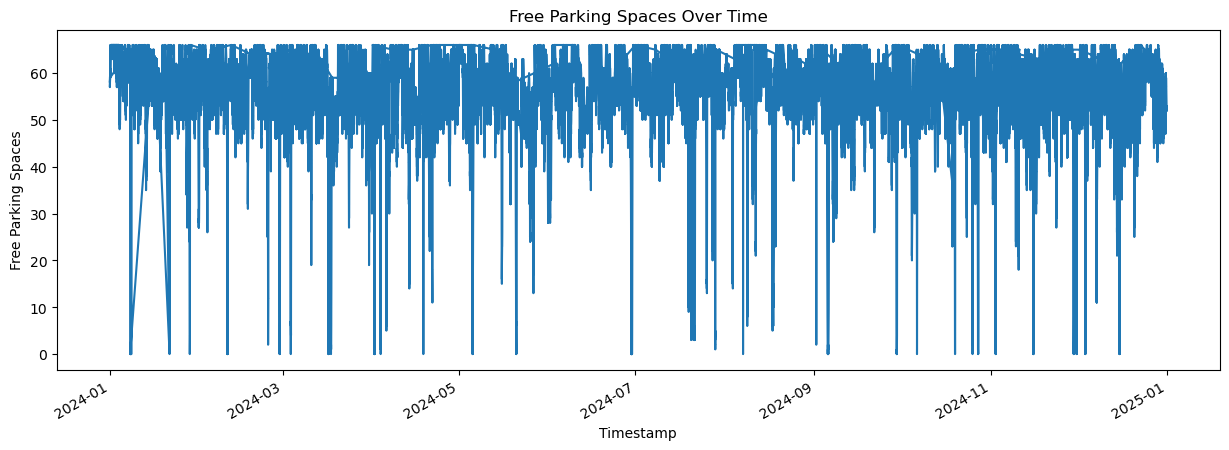

In [ ]:
import matplotlib.pyplot as plt

# Convert the 'timestamp' column to datetime
df_parkhaus_data_2024['timestamp'] = pd.to_datetime(df_parkhaus_data_2024['timestamp'])

# Set the 'timestamp' column as the index
df_parkhaus_data_2024.set_index('timestamp', inplace=True)

# Plot the time series data
df_parkhaus_data_2024['free'].plot(figsize=(15, 5), title='Free Parking Spaces Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Free Parking Spaces')
plt.show()

# Webscraping

In [ ]:
# Install the selenium package
#%pip install selenium

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time
import re

In [ ]:

# --- Define scraping functions ---

def extract_number(text):
    """
    Extracts the first float or integer found in the text.
    Returns the value as a float, or None if no number is found.
    """
    match = re.search(r"[-+]?\d*\.\d+|\d+", text)
    if match:
        return float(match.group())
    return None

def scrape_temperature(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    temp_header = soup.find('th', string=lambda text: text and 'Day Average Temp' in text)
    if temp_header:
        temp_value = temp_header.find_next('td')
        if temp_value:
            try:
                return float(temp_value.text.strip())
            except Exception as e:
                print("Temperature conversion error:", e)
    return None

def scrape_max_wind(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    wind_header = soup.find('th', string=lambda text: text and 'Max Wind Speed' in text)
    if wind_header:
        wind_value = wind_header.find_next('td')
        if wind_value:
            try:
                # Extract the first numeric value
                return extract_number(wind_value.text.strip())
            except Exception as e:
                print("Wind conversion error:", e)
    return None

def scrape_sea_level_pressure(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    pressure_header = soup.find('th', string=lambda text: text and 'Sea Level Pressure' in text)
    if pressure_header:
        pressure_value = pressure_header.find_next('td')
        if pressure_value:
            try:
                # Use the extract_number function to get the first numeric value
                return extract_number(pressure_value.text.strip())
            except Exception as e:
                print("Pressure conversion error:", e)
    return None



In [ ]:

# Uncomment the following lines to fetch the data from the Parkendd API for the year 2024
# We have commented the code to avoid unnecessary API calls
"""
# --- Setup Selenium driver ---
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

# --- Prepare to loop through all days of 2024 ---
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
current_date = start_date

weather_data = []

while current_date <= end_date:
    # Construct the URL in the format required by Wunderground
    url = f"https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/{current_date.year}-{current_date.month}-{current_date.day}"
    print("Scraping:", url)
    
    try:
        driver.get(url)
        # Wait for the dynamic content to load (adjust the sleep time as necessary)
        time.sleep(5)
        html_content = driver.page_source
        
        # Extract data using the scraping functions
        avg_temp = scrape_temperature(html_content)
        max_wind = scrape_max_wind(html_content)
        sea_level_pressure = scrape_sea_level_pressure(html_content)
        
        weather_data.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "day_avg_temp": avg_temp,
            "max_wind_speed": max_wind,
            "sea_level_pressure": sea_level_pressure
        })
    except Exception as e:
        print(f"Error on {current_date.strftime('%Y-%m-%d')}: {e}")
        weather_data.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "day_avg_temp": None,
            "max_wind_speed": None,
            "sea_level_pressure": None
        })
    
    # Move to the next day
    current_date += timedelta(days=1)

# Close the Selenium driver
driver.quit()

# Save results to CSV
df = pd.DataFrame(weather_data)
print(df.head())
df.to_csv("weather_2024_lszh.csv", index=False)"
"""

Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-1
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-2
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-3
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-4
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-5
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-6
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-7
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-8
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-9
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-10
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-11
Scraping: https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/2024-1-12


KeyboardInterrupt: 

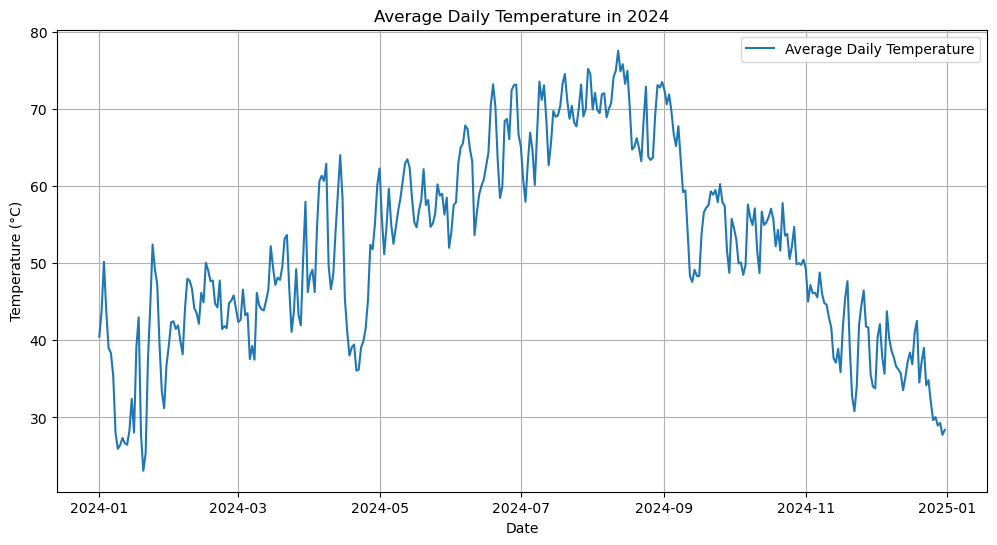

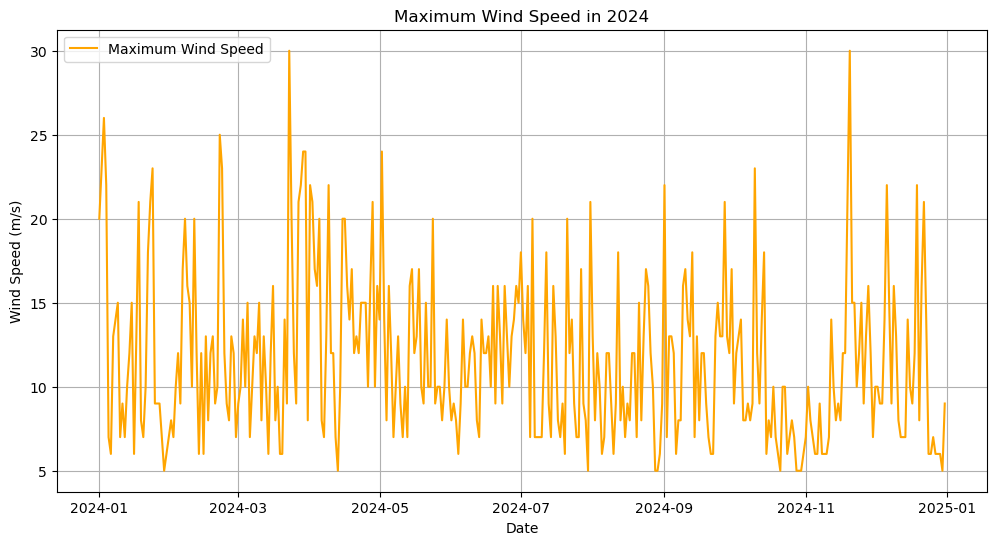

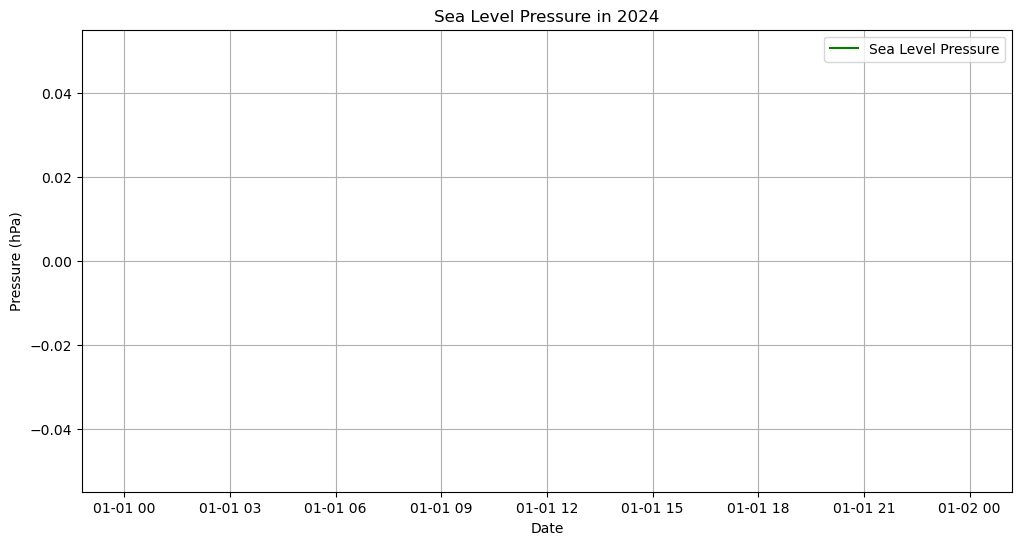

In [11]:
import pandas as pd

import matplotlib.pyplot as plt

# Load the weather data from the CSV file
df_weather_2024 = pd.read_csv("weather_2024_lszh.csv")

# Convert the 'date' column to datetime objects
df_weather_2024['date'] = pd.to_datetime(df_weather_2024['date'])

# Set 'date' as the index of the DataFrame
df_weather_2024.set_index('date', inplace=True)

# Plotting the average daily temperature
plt.figure(figsize=(12, 6))
plt.plot(df_weather_2024['day_avg_temp'], label='Average Daily Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Average Daily Temperature in 2024')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the maximum wind speed
plt.figure(figsize=(12, 6))
plt.plot(df_weather_2024['max_wind_speed'], label='Maximum Wind Speed', color='orange')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Maximum Wind Speed in 2024')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the sea level pressure
plt.figure(figsize=(12, 6))
plt.plot(df_weather_2024['sea_level_pressure'], label='Sea Level Pressure', color='green')
plt.xlabel('Date')
plt.ylabel('Pressure (hPa)')
plt.title('Sea Level Pressure in 2024')
plt.legend()
plt.grid(True)
plt.show()